In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import radians, sin, cos, sqrt, atan2

In [24]:
# Load location data from a CSV file
df = pd.read_csv(r'data/vpt_locations.csv')

# Define a function to calculate the distance between two coordinates using the Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Compute the differences in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of the Earth in kilometers
    return r * c  # Return the distance in kilometers

# Extract location names, latitudes, and longitudes into separate lists
locations = df['Location'].tolist()
latitudes = df['Lat'].tolist()
longitudes = df['Lon'].tolist()

# Compute the distance matrix between all location pairs
distance_matrix = []
for i in range(len(locations)):
    row = []
    for j in range(len(locations)):
        distance = haversine(longitudes[i], latitudes[i], longitudes[j], latitudes[j])
        row.append(distance)
    distance_matrix.append(row)

# Convert the list of lists into a NumPy array
distance_matrix = np.array(distance_matrix)

# Save the distance matrix to a CSV file
np.savetxt(r'data/distance_matrix.csv', distance_matrix, delimiter=",", fmt='%.6f')


In [25]:
# Load the OD (origin-destination) demand matrix from a CSV file
array = np.loadtxt(r'data/demand.csv', delimiter=',')

# Calculate total outflow from each node (row-wise sum)
outflow = array.sum(axis=1)

# Calculate total inflow to each node (column-wise sum) and normalize by 24 time units
inflow = array.sum(axis=0)
inflow /= 24  # Assumes demand matrix is aggregated over 24 time units (e.g., hours)

# Print the total arrival rate (should equal total departure rate if balanced)
print(np.sum(inflow))

# Compute the choice probability matrix: probability of going from i to j
# Each row of the matrix sums to 1 (or close to it, depending on zero outflows)
outflow_ratio = array / outflow[:, np.newaxis]

# Save the arrival rate vector and choice probability matrix to CSV files
np.savetxt(r'data/arrival_rate_vector.csv', inflow, delimiter=',', fmt='%.5f')
np.savetxt(r'data/choice_probability_matrix.csv', outflow_ratio, delimiter=',', fmt='%.5f')

# Define a function to check if a Markov chain is irreducible
def is_irreducible(matrix):
    n = matrix.shape[0]
    reachability = np.copy(matrix)  # Initialize reachability matrix with one-step transitions
    for i in range(2, n + 1):  # Compute higher powers to check for multi-step reachability
        reachability = np.dot(reachability, matrix)
        reachability[reachability > 0] = 1  # Binary reachability: 1 if a path exists

    # A chain is irreducible if every state is reachable from every other state
    return np.all(reachability > 0)

# Check and report whether the Markov chain defined by the transition matrix is irreducible
if is_irreducible(outflow_ratio):
    print("This Markov chain is irreducible.")
else:
    print("This Markov chain is not irreducible.")

3985.5
This Markov chain is irreducible.


In [26]:
# Read the choice probability matrix (transition probabilities between vertiports)
P = np.loadtxt(r'data/choice_probability_matrix.csv', delimiter=',')
print(P.shape)

# A set of vertiport locations (assumes df is already defined)
locations = df['Location'].tolist()

# Define all possible flight corridors as (origin, destination) pairs, excluding self-loops
flight_corridors = [(i, j) for i in locations for j in locations if i != j]

# Define all nodes in the network: vertiports and flight corridors
nodes = locations + flight_corridors

# Create a mapping from each node to its index in the combined node list
node_idx = {node: idx for idx, node in enumerate(nodes)}

# Initialize the routing matrix (size: number of nodes x number of nodes)
R = np.zeros((len(nodes), len(nodes)))

# Build the routing matrix by defining valid transitions between nodes
for i_node in nodes:
    for j_node in nodes:
        i_idx = node_idx[i_node]
        j_idx = node_idx[j_node]

        # Case 1: From a vertiport to a flight corridor (only if it departs from that vertiport)
        if isinstance(i_node, str) and isinstance(j_node, tuple):
            entry, exit = j_node
            if i_node == entry:
                # Assign the probability of transitioning from entry to exit
                R[i_idx, j_idx] = P[node_idx[entry], node_idx[exit]]

        # Case 2: From a flight corridor to a vertiport (only if it arrives at that vertiport)
        elif isinstance(i_node, tuple) and isinstance(j_node, str):
            entry, exit = i_node
            if j_node == exit:
                # Deterministic transition: a corridor always leads to its destination
                R[i_idx, j_idx] = 1

# Save the resulting routing matrix to a CSV file
np.savetxt(r'data/routing_matrix.csv', R, delimiter=',', fmt='%.5f')

(10, 10)


In [27]:
# Parameters for UAM (Urban Air Mobility) travel time components
cruise_speed = 241        # Cruise speed in km/h
takeoff_time = 1          # Time required for takeoff (in minutes)
landing_time = 1          # Time required for landing (in minutes)
taxi_time = 2             # Time for taxi-in and taxi-out (in minutes)

# Total fixed time per trip (in minutes): taxi-out + takeoff + landing + taxi-in
procedure_time = takeoff_time + landing_time + taxi_time * 2

# Load the pairwise distance matrix between vertiports (in kilometers)
distances = np.loadtxt(r'data/distance_matrix.csv', delimiter=',')

# Compute the total travel time matrix (in hours)
# Formula: fixed procedure time (converted to hours) + in-flight time based on cruise speed
T = procedure_time / 60 + (distances / cruise_speed)

# Print shape of the resulting travel time matrix
print(T.shape)

# Save the travel time matrix to a CSV file
np.savetxt(r'data/travel_time_matrix.csv', T, delimiter=',', fmt='%.5f')

(10, 10)


In [28]:
# Load routing matrix R
R = np.loadtxt(r'data/routing_matrix.csv', delimiter=',')

# Compute left eigenvectors of R: Solve \pi R = \pi
evals, evecs = np.linalg.eig(R.T)

# Find the eigenvalue closest to 1
idx = np.argmin(np.abs(evals - 1))  

# Extract corresponding eigenvector
pi = np.real(evecs[:, idx])
# print(pi.shape)

np.savetxt(r'data/relative_throughput_vector.csv', pi, delimiter=',', fmt='%.5f')

In [29]:
# Load vertiport and node data
df = pd.read_csv(r'data/vpt_locations.csv')

locations = df['Location'].tolist()
flight_corridors = [(i, j) for i in locations for j in locations if i != j]
nodes = locations + flight_corridors
node_idx = {node: idx for idx, node in enumerate(nodes)}
loc_index = {loc: idx for idx, loc in enumerate(locations)}

# Load required data
R = np.loadtxt(r'data/routing_matrix.csv', delimiter=',')             # Routing matrix
T = np.loadtxt(r'data/travel_time_matrix.csv', delimiter=',')         # Travel time matrix (vertiport level)
D = np.loadtxt(r'data/distance_matrix.csv', delimiter=',')            # Distance matrix (vertiport level)
lambda_vec = np.loadtxt(r'data/arrival_rate_vector.csv', delimiter=',')  # Passenger arrival rate vector
c_usage_vec = np.ones(len(locations))                                 # Initialize usage cost vector
pi_vec = np.loadtxt(r'data/relative_throughput_vector.csv', delimiter=',')  # Relative throughput vector

### Input Parameters ###
tol = 0.5            # Minimum availability requirement
c_fare = 2000        # Fare per km (KRW)
c_usage = 5000       # Vertiport usage cost per operation (KRW)
c_mnt = 2500         # Vehicle maintenance cost per unit (KRW)
lambda_total = 200   # Total arrival rate into the system (passengers/hour)

# Cost Vector Computations
# Compute fare per corridor (distance * fare per km)
c_fare_vec = np.array([D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors])
# Update usage cost vector
c_usage_vec *= c_usage
# Compute effective compen vector (compen minus usage fee)

# Scale arrival rate vector
lambda_props = lambda_vec / np.sum(lambda_vec)      # Normalize
lambda_vec = lambda_props * lambda_total            # Scale to total demand

# Compute base service rates for flight corridors
n_vpt = len(locations)
n_total = len(nodes)
base_mu = np.zeros(n_total)
for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
    base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]

# Compute service rates for each node (mu_i(1))
mu_1 = np.zeros(n_total)
mu_1[:n_vpt] = lambda_vec          # For vertiports: service rate = arrival rate
mu_1[n_vpt:] = base_mu[n_vpt:]     # For corridors: service rate = 1 vehicle per travel time

# Compute gamma values for optimization
pi_vpt = pi_vec[:n_vpt]
pi_cdr = pi_vec[n_vpt:]
gamma_base = pi_cdr / mu_1[n_vpt:]


# ESS Algorithm: Find optimal number of vehicles
obj_history = []
n_history = []
availability_history = []

W = [np.zeros(n_total)]     # List of response time vectors
L = [np.zeros(n_total)]     # List of queue length vectors
n = 0                       # Current number of vehicles
m_min = -1                  # First n satisfying availability constraint
obj_prev = 0                # Previous objective value

while True:
    n += 1

    # Step 1: Mean Value Analysis (MVA) for response times
    W_vector = np.zeros(n_total)
    for node in nodes:
        idx = node_idx[node]
        if isinstance(node, tuple):  # corridor
            W_vector[idx] = 1.0 / mu_1[idx]
        else: # vertiport
            W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]

    # System throughput: X(n)
    Xn = n / np.dot(pi_vec, W_vector)

    # Queue length: L(n)
    L_vector = Xn * pi_vec * W_vector
    W.append(W_vector)
    L.append(L_vector)

    # Step 2: Check availability constraint
    availability = [
        Xn * pi_vec[node_idx[loc]] / lambda_vec[loc_index[loc]]
        for loc in locations
    ]
    availability_history.append(availability)

    if m_min == -1 and all(a >= tol for a in availability):
        m_min = n  # Minimum fleet size satisfying availability

    # Step 3: Objective function evaluation
    if m_min != -1 and n >= m_min:
        L_corridors = L_vector[n_vpt:]                # Queue lengths on corridors
        Lambda_vector = Xn * pi_vec                   # Flow at each node
        Lambda_vertiports = Lambda_vector[:n_vpt]

        # Objective: max profit = revenue - vertiport usage cost - maintenance cost
        obj_n = (
            np.dot(c_fare_vec, L_corridors)
            - np.dot(c_usage_vec, Lambda_vertiports)
            - c_mnt * n
        )

        obj_history.append(obj_n)
        n_history.append(n)

        # Stop if objective decreases
        if obj_n < obj_prev:
            m_star = n - 1
            break
        obj_prev = obj_n

# Final Results
print(f"Minimum fleet size m_min = {m_min}")
print(f"Optimal fleet size m* = {m_star}")
print(f"Objective value = {obj_prev}")


Minimum fleet size m_min = 30
Optimal fleet size m* = 40
Objective value = 75810.92599985842


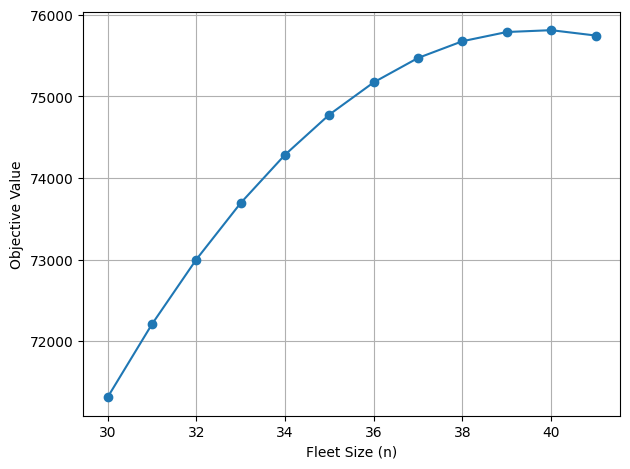

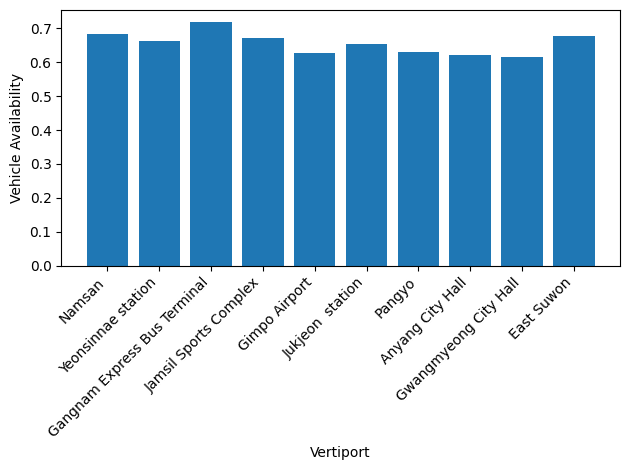

Final Availability: [0.6822677652864911, 0.6618964518741454, 0.7179893574122854, 0.6723214360782154, 0.6276697216662706, 0.6539864212615955, 0.630119927079185, 0.6213998974051995, 0.6158854312092518, 0.6760967220152729]


In [30]:
def plot_objective_vs_fleet_size(n_history, obj_history, save_path=None):
    """
    Plot the objective value vs. fleet size.

    Parameters:
        n_history (list): List of fleet sizes evaluated.
        obj_history (list): Corresponding objective values.
        save_path (str, optional): If provided, saves the plot to this file path.
    """
    plt.figure()
    plt.plot(n_history, obj_history, marker='o')
    plt.xlabel('Fleet Size (n)')
    plt.ylabel('Objective Value')
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


def plot_vehicle_availability(locations, availability, m_star, save_path=None):
    """
    Plot vehicle availability at each vertiport.

    Parameters:
        locations (list): List of vertiport names.
        availability (list): Availability values for each vertiport.
        m_star (int): Optimal fleet size (for title).
        save_path (str, optional): If provided, saves the plot to this file path.
    """
    plt.figure()
    plt.bar(locations, availability)
    plt.xlabel('Vertiport')
    plt.ylabel('Vehicle Availability')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()
    print("Final Availability:", availability)
    
    
# Example usage after ESS algorithm
plot_objective_vs_fleet_size(
    n_history=n_history,
    obj_history=obj_history,
    save_path=r"result\fig_objective_vs_fleet_size.png"
)

plot_vehicle_availability(
    locations=locations,
    availability=availability_history[-1],
    m_star=m_star,
    save_path=r"result\fig_veh_availability.png"
)


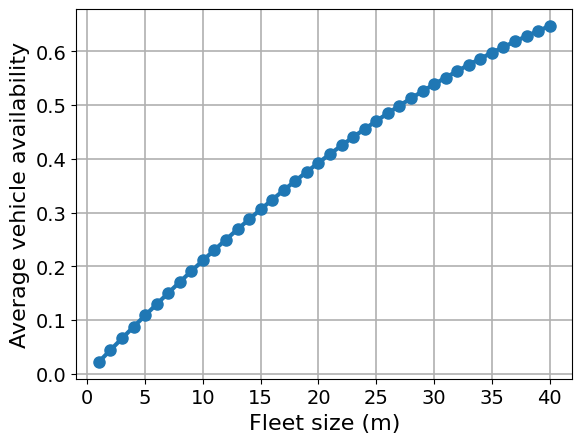

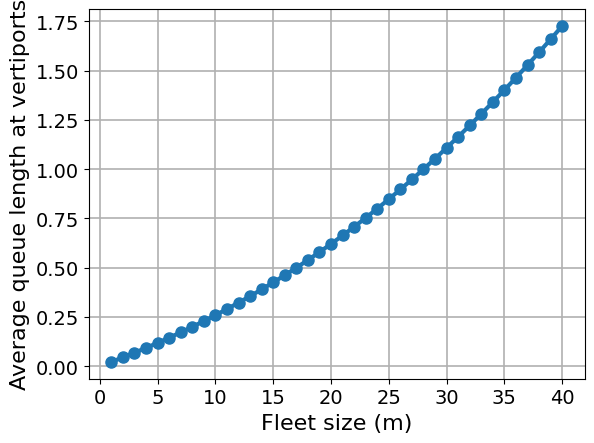

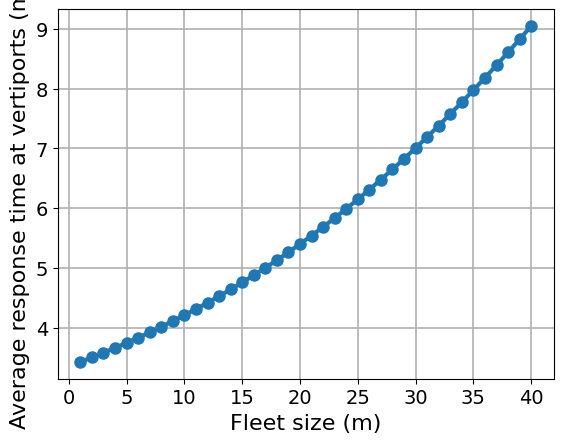

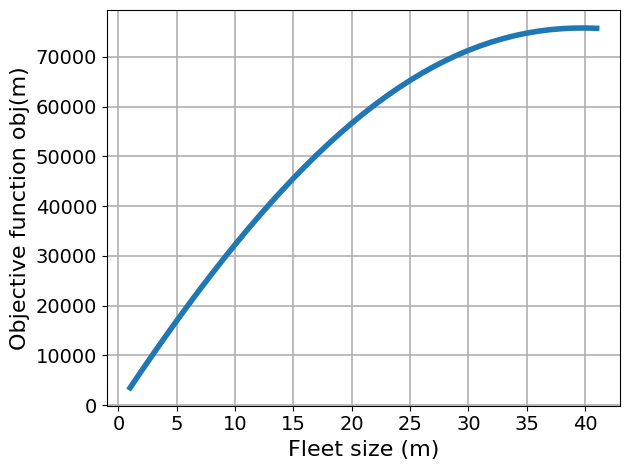

Minimum fleet size: 30
Optimal fleet size: 40


In [31]:
def run_ess_simulation(
    locations,
    flight_corridors,
    lambda_vec,
    pi_vec,
    T,
    D,
    tol=0.5,
    c_fare=2000,
    c_usage=5000,
    c_mnt=2500,
    lambda_total=200,
    max_fleet=80
):

    # Define indexing
    nodes = locations + flight_corridors
    node_idx = {node: idx for idx, node in enumerate(nodes)}
    loc_index = {loc: idx for idx, loc in enumerate(locations)}

    n_vpt = len(locations)
    n_total = len(nodes)

    # Cost vectors
    c_fare_vec = np.array([
        D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors
    ])
    c_usage_vec = np.ones(n_vpt) * c_usage
    
    # Scale arrival rate
    lambda_vec = lambda_vec / np.sum(lambda_vec) * lambda_total

    # Base service rates
    base_mu = np.zeros(n_total)
    for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
        base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]

    mu_1 = np.zeros(n_total)
    mu_1[:n_vpt] = lambda_vec
    mu_1[n_vpt:] = base_mu[n_vpt:]

    # ESS loop
    obj_history = []
    n_history = []
    availability_history = []
    avg_availability_history = []
    W, L = [np.zeros(n_total)], [np.zeros(n_total)]
    m_min, obj_prev = -1, 0
    m_star = None
    
    for n in range(1, max_fleet + 1):
        # Response time estimation
        W_vector = np.zeros(n_total)
        for node in nodes:
            idx = node_idx[node]
            if isinstance(node, tuple):
                W_vector[idx] = 1.0 / mu_1[idx]
            else:
                W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]

        Xn = n / np.dot(pi_vec, W_vector)
        L_vector = Xn * pi_vec * W_vector

        A = np.array([
            Xn * pi_vec[node_idx[loc]] / lambda_vec[loc_index[loc]]
            for loc in locations
        ])

        avg_availability_history.append(A.mean())
        availability_history.append(A)
        W.append(W_vector)
        L.append(L_vector)

        # Objective evaluation
        L_corridors = L_vector[n_vpt:]
        Lambda_vector = Xn * pi_vec
        Lambda_vertiports = Lambda_vector[:n_vpt]
        
        obj_n = (
            np.dot(c_fare_vec, L_corridors)
            - np.dot(c_usage_vec, Lambda_vertiports)
            - c_mnt * n
        )
        n_history.append(n)
        obj_history.append(obj_n)

        if m_min == -1 and np.all(A >= tol):
            m_min = n

        if obj_n < obj_prev:
            m_star = n - 1
            break

        obj_prev = obj_n

    # Compute average queue lengths and response times at vertiports
    avg_L_history, avg_W_history = [], []
    for m in range(1, m_star + 1):
        avg_L_history.append(L[m][:n_vpt].mean())
        avg_W_history.append((W[m][:n_vpt] * 60).mean())  # in minutes

    return {
        'm_min': m_min,
        'm_star': m_star,
        'n_history': n_history,
        'obj_history': obj_history,
        'avg_availability_history': avg_availability_history,
        'avg_L_history': avg_L_history,
        'avg_W_history': avg_W_history,
    }

def plot_ess_results(results, save_dir="result"):

    os.makedirs(save_dir, exist_ok=True)

    m_star = results['m_star']

    # Plot average vehicle availability
    plt.figure()
    plt.plot(range(1, m_star + 1), results['avg_availability_history'][:m_star],
             marker='o', linewidth=3, markersize=8)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Average vehicle availability', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.savefig(os.path.join(save_dir, "fig_avg_veh_availability.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # Plot average queue length
    plt.figure()
    plt.plot(range(1, m_star + 1), results['avg_L_history'],
             marker='o', linewidth=3, markersize=8)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Average queue length at vertiports', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.savefig(os.path.join(save_dir, "fig_avg_queue_length.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # Plot average response time
    plt.figure()
    plt.plot(range(1, m_star + 1), results['avg_W_history'],
             marker='o', linewidth=3, markersize=8)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Average response time at vertiports (min)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.savefig(os.path.join(save_dir, "fig_avg_response_time.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # Plot objective function
    plt.figure()
    plt.plot(results['n_history'], results['obj_history'], linewidth=4)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Objective function obj(m)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "fig_obj_function.png"), dpi=600, bbox_inches='tight')
    plt.show()

results = run_ess_simulation(
    locations=locations,
    flight_corridors=flight_corridors,
    lambda_vec=lambda_vec,
    pi_vec=pi_vec,
    T=T,
    D=D,
    tol=0.5,
    lambda_total=200
)

plot_ess_results(results)
print(f"Minimum fleet size: {results['m_min']}")
print(f"Optimal fleet size: {results['m_star']}")

c_pen=0: optimal fleet size m*=40, obj*=75810.93
c_pen=500: optimal fleet size m*=48, obj*=44635.29
c_pen=1000: optimal fleet size m*=55, obj*=18586.29


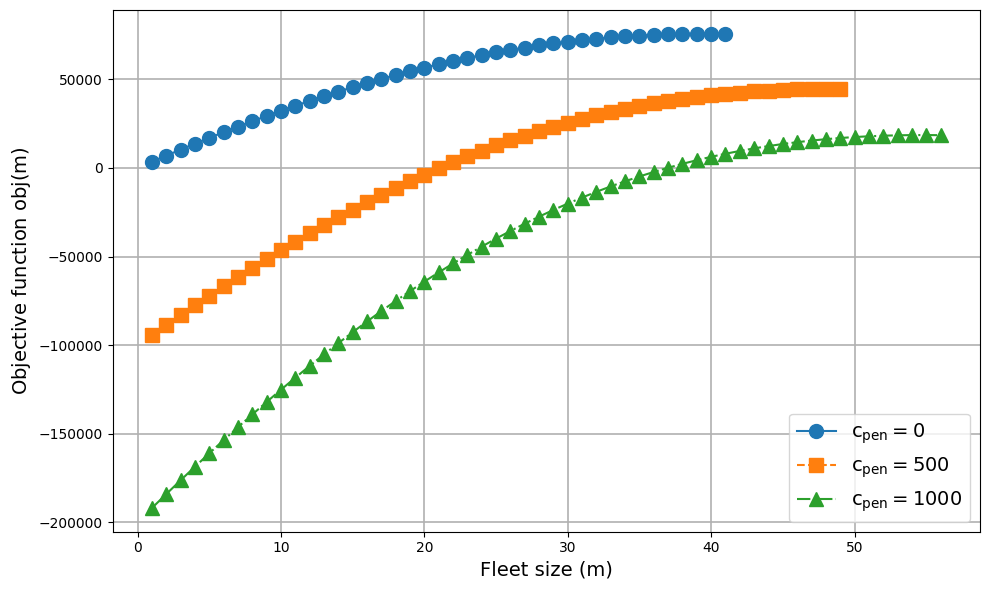

In [32]:
def run_ess_simulation_compen(
    c_pen=0,
    vpt_csv='data/vpt_locations.csv',
    routing_csv='data/routing_matrix.csv',
    time_csv='data/travel_time_matrix.csv',
    dist_csv='data/distance_matrix.csv',
    arrival_csv='data/arrival_rate_vector.csv',
    throughput_csv='data/relative_throughput_vector.csv',
    tol=0.5,
    c_fare=2000,
    c_usage=5000,
    c_mnt=2500,
    lambda_total=200,
    max_m=100
):
    
    # Load data and set up nodes/corridors
    df        = pd.read_csv(vpt_csv)
    locs      = df['Location'].tolist()
    corridors = [(i, j) for i in locs for j in locs if i != j]
    n_vpt     = len(locs)
    n_nodes   = n_vpt + len(corridors)
    loc_idx   = {loc: i for i, loc in enumerate(locs)}
    node_list = locs + corridors
    node_idx  = {node: i for i, node in enumerate(node_list)}

    # Load matrices and vectors
    T          = np.loadtxt(time_csv,    delimiter=',')
    D          = np.loadtxt(dist_csv,    delimiter=',')
    lambda_raw = np.loadtxt(arrival_csv, delimiter=',')
    pi_vec     = np.loadtxt(throughput_csv, delimiter=',')

    # Cost and fare vectors
    c_usage_vec = np.ones(n_vpt) * c_usage
    fare_vec    = np.array([D[loc_idx[i], loc_idx[j]] * c_fare 
                            for i, j in corridors])

    # Scale arrival rates to total
    props      = lambda_raw / lambda_raw.sum()
    lambda_vec = props * lambda_total
    
    # Compute mu_1 for each node
    base_mu = np.zeros(n_nodes)
    for idx, (i, j) in enumerate(corridors, start=n_vpt):
        base_mu[idx] = 1.0 / T[loc_idx[i], loc_idx[j]]
    mu_1 = np.zeros(n_nodes)
    mu_1[:n_vpt]   = lambda_vec     # vertiports
    mu_1[n_vpt:]   = base_mu[n_vpt:]  # corridors

    # Perform MVA-ESS to build history
    n_history = []
    obj_history = []
    L_prev = np.zeros(n_nodes)
    obj_prev = -np.inf

    for n in range(1, max_m + 1):
        # MVA: compute response times W and queue lengths L
        W = np.zeros(n_nodes)
        for node in node_list:
            idx = node_idx[node]
            if isinstance(node, tuple):
                W[idx] = 1.0 / mu_1[idx]
            else:
                W[idx] = (1 + L_prev[idx]) / lambda_vec[loc_idx[node]]
        Xn = n / np.dot(pi_vec, W)
        L  = Xn * pi_vec * W

        # Compute compen term from lost arrivals
        A = np.array([Xn * pi_vec[node_idx[loc]] / lambda_vec[loc_idx[loc]] for loc in locs])
        lost_rate = lambda_vec * (1 - A)
        pen_term = c_pen * lost_rate.sum()

        # Objective function including compen
        Lambda_v = Xn * pi_vec[:n_vpt]
        obj = (
            fare_vec.dot(L[n_vpt:])    # fare revenue
        - c_usage_vec.dot(Lambda_v)  # usage fee
        - c_mnt * n                  # maintenance cost
        - pen_term               # compen cost
        )

        # Record history
        n_history.append(n)
        obj_history.append(obj)
        L_prev = L

        # Stop if objective decreases
        if obj < obj_prev:
            m_star = n - 1
            break
        obj_prev = obj

    return n_history, obj_history, m_star


# Plotting
penalties   = [0, 500, 1000]
linestyles  = ['-', '--', '-.']
markers     = ['o', 's', '^']

plt.figure(figsize=(10, 6))
for cp, ls, mk in zip(penalties, linestyles, markers):
    n_hist, obj_hist, m_star = run_ess_simulation_compen(cp)
    # Print optimal results for each compen
    print(f"c_pen={cp}: optimal fleet size m*={m_star}, obj*={obj_hist[m_star-1]:.2f}")

    # Plot the objective curve
    plt.plot(
    n_hist, obj_hist,
    linestyle=ls,
    marker=mk,
    markersize=10,
    label=fr'$c_{{pen}}={cp}$'  # LaTeX-formatted legend
    )

# Configure axes and grid
plt.xlabel('Fleet size (m)', fontsize=14)
plt.ylabel('Objective function $obj(m)$', fontsize=14)
# plt.title('Objective vs Fleet Size with compen Term\nand Optimal Annotations', fontsize=16)
plt.grid(True, linewidth=1.2)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('result/fig_compen_scheme')
plt.show()